# Analyze feature importance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss,accuracy_score 
from scipy.stats import weightedtau

import sys
sys.path.insert(0, '..')
from multiprocess import mp_pandas_obj as mpPandasObj

In [15]:
X = pd.read_csv("../data/x.csv", index_col=0, parse_dates=True)
cont = pd.read_csv("../data/cont.csv", index_col=0, parse_dates=[0,3])

In [16]:
## Sort index? Drop nans?
X.sort_index(inplace=True)
cont.sort_index(inplace=True)
X.dropna(inplace=True)
cont = cont.loc[X.index[0]:]

In [17]:
class PurgedKFold(KFold):
    #Extend KFold class to work with labels that span intervals
    #The train is purged of observations overlapping test-label intervals
    #Test set is assumed contiguous (shuffle=False), w/o training samples in between 
    def __init__(self,n_splits=3,t1=None,pctEmbargo=0.):
        if not isinstance(t1,pd.Series):
            raise ValueError('Label Through Dates must be a pd.Series')
        super(PurgedKFold,self).__init__(n_splits,shuffle=False,random_state=None) 
        self.t1=t1
        self.pctEmbargo=pctEmbargo
    def split(self,X,y=None,groups=None):
        if (X.index==self.t1.index).sum()!=len(self.t1):
            raise ValueError('X and ThruDateValues must have the same index') 
        indices=np.arange(X.shape[0])
        mbrg=int(X.shape[0]*self.pctEmbargo)
        test_starts=[(i[0],i[-1]+1) for i in \
            np.array_split(np.arange(X.shape[0]),self.n_splits)] 
        for i,j in test_starts:
            t0=self.t1.index[i] # start of test set
            test_indices=indices[i:j] 
            maxT1Idx=self.t1.index.searchsorted(self.t1[test_indices].max()) 
            train_indices=self.t1.index.searchsorted(self.t1[self.t1<=t0].index) 
            if maxT1Idx<X.shape[0]: # right train (with embargo)
                train_indices=np.concatenate((train_indices,indices[maxT1Idx+mbrg:])) 
            yield train_indices,test_indices

In [18]:
def test_data_func(X, cont, run='', allow_masking_effects=False, methods=['MDI', 'MDA', 'SFI']):
    for method in methods:
        feature_imp, oob_score, oos_score = featImportance(X, cont, cv=5, method=method)
        plotFeatImportance("pathout",feature_imp,oob_score,oos_score, method=method)


def featImportance(trnsX,cont,n_estimators=1000,cv=10,max_samples=1.,numThreads=24, pctEmbargo=0,scoring='accuracy',method='SFI',minWLeaf=0.,**kargs):
    '''feature importance from a random forest'''
    n_jobs=(-1 if numThreads>1 else 1) # run 1 thread with ht_helper in dirac1 
    #1) prepare classifier,cv. max_features=1, to prevent masking 
    clf=DecisionTreeClassifier(criterion='entropy',max_features=1,class_weight='balanced',min_weight_fraction_leaf=minWLeaf) 
    clf=BaggingClassifier(base_estimator=clf,n_estimators=n_estimators,max_features=1.,max_samples=max_samples,oob_score=True,n_jobs=n_jobs) 
    fit=clf.fit(X=trnsX,y=cont['target'],sample_weight=cont['wd'].values) 
    oob=fit.oob_score_
    if method=='MDI':
        imp=featImpMDI(fit,featNames=trnsX.columns) 
        oos=cvScore(clf,X=trnsX,y=cont['target'],cv=cv,sample_weight=cont['wd'],
                    t1=cont['t1'],pctEmbargo=pctEmbargo,scoring=scoring).mean() 
    elif method=='MDA':
        imp,oos=featImpMDA(clf,X=trnsX,y=cont['target'],cv=cv,sample_weight=cont['wd'], 
                           t1=cont['t1'],pctEmbargo=pctEmbargo,scoring=scoring)
    elif method=='SFI': 
        cvGen=PurgedKFold(n_splits=cv,t1=cont['t1'],pctEmbargo=pctEmbargo) 
        oos=cvScore(clf,X=trnsX,y=cont['target'],sample_weight=cont['wd'],scoring=scoring,
                    cvGen=cvGen).mean()
        clf.n_jobs=1 # paralellize auxFeatImpSFI rather than clf 
        imp=mpPandasObj(auxFeatImpSFI,('featNames',trnsX.columns),numThreads,
                        clf=clf,trnsX=trnsX,cont=cont,scoring=scoring,cvGen=cvGen) 
    return imp,oob,oos

def plotFeatImportance(pathOut,imp,oob,oos,method,tag=0,simNum=0,**kargs): 
    '''plot mean imp bars with std'''
    plt.figure(figsize=(10,imp.shape[0]/5.)) 
    imp=imp.sort_values('mean',ascending=True) 
    ax=imp['mean'].plot(kind='barh',color='b',alpha=.25,xerr=imp['std'],error_kw={'ecolor':'r'})
    if method=='MDI':
        plt.xlim([0,imp.sum(axis=1).max()]) 
        plt.axvline(1./imp.shape[0],linewidth=1,color='r',linestyle='dotted')
    ax.get_yaxis().set_visible(False)
    for i,j in zip(ax.patches,imp.index):
        ax.text(i.get_width()/2, i.get_y()+i.get_height()/2,j,ha='center',va='center',
                color='black')
    plt.title('tag='+str(tag)+' | simNum='+str(simNum)+' | oob='+str(round(oob,4))+
    ' | oos='+str(round(oos,4))) 
#     plt.savefig(pathOut+'featImportance_'+str(simNum)+'.png',dpi=100) 
#     plt.clf();plt.close()
    plt.show()
    return

def featImpMDI(fit,featNames):
    # feat importance based on IS mean impurity reduction
    df0={i:tree.feature_importances_ for i,tree in enumerate(fit.estimators_)} 
    df0=pd.DataFrame.from_dict(df0,orient='index')
    df0.columns=featNames
    df0=df0.replace(0,np.nan) # because max_features=1
    imp=pd.concat({'mean':df0.mean(),'std':df0.std()*df0.shape[0]**-.5},axis=1) 
    imp/=imp['mean'].sum()
    return imp

def featImpMDA(clf,X,y,cv,sample_weight,t1,pctEmbargo,scoring='neg_log_loss'): 
    '''    
    feat importance based on OOS score reduction
    '''    
    if scoring not in ['neg_log_loss','accuracy']:
        raise Exception('wrong scoring method.')
    
    cvGen=PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo) # purged cv 
    scr0,scr1=pd.Series(),pd.DataFrame(columns=X.columns)

    for i,(train,test) in enumerate(cvGen.split(X=X)): 
        X0,y0,w0=X.iloc[train,:],y.iloc[train],sample_weight.iloc[train] 
        X1,y1,w1=X.iloc[test,:],y.iloc[test],sample_weight.iloc[test] 
        fit=clf.fit(X=X0,y=y0,sample_weight=w0.values)
        if scoring=='neg_log_loss':
            prob=fit.predict_proba(X1) 
            scr0.loc[i]=-log_loss(y1,prob,sample_weight=w1.values,labels=clf.classes_)
        else:
            pred=fit.predict(X1) 
            scr0.loc[i]=accuracy_score(y1,pred,sample_weight=w1.values)
        for j in X.columns:
            X1_=X1.copy(deep=True)
            np.random.shuffle(X1_[j].values) # permutation of a single column 
            if scoring=='neg_log_loss':
                prob=fit.predict_proba(X1_) 
                scr1.loc[i,j]=-log_loss(y1,prob,sample_weight=w1.values,labels=clf.classes_)
            else:
                pred=fit.predict(X1_) 
                scr1.loc[i,j]=accuracy_score(y1,pred,sample_weight=w1.values)
    imp=(-scr1).add(scr0,axis=0)
    if scoring=='neg_log_loss':
        imp=imp/-scr1
    else:
        imp=imp/(1.-scr1) 
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1) 
    return imp,scr0.mean()

def auxFeatImpSFI(featNames,clf,trnsX,cont,scoring,cvGen): 
    imp=pd.DataFrame(columns=['mean','std'])
    for featName in featNames:
        df0=cvScore(clf,X=trnsX[[featName]],y=cont['target'],sample_weight=cont['wd'], scoring=scoring,cvGen=cvGen)
        imp.loc[featName,'mean']=df0.mean()
        imp.loc[featName,'std']=df0.std()*df0.shape[0]**-.5 
    return imp

def cvScore(clf,X,y,sample_weight,scoring='neg_log_loss',t1=None,cv=None,cvGen=None, pctEmbargo=None):
    if scoring not in ['neg_log_loss','accuracy']: 
        raise Exception('wrong scoring method.')
    if cvGen is None:
        cvGen=PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo) # purged 
    score=[]
    for train,test in cvGen.split(X=X): 
        fit=clf.fit(X=X.iloc[train,:],y=y.iloc[train],sample_weight=sample_weight.iloc[train].values) 
        if scoring=='neg_log_loss':
            prob=fit.predict_proba(X.iloc[test,:]) 
            score_=-log_loss(y.iloc[test],prob, sample_weight=sample_weight.iloc[test].values,labels=clf.classes_)
        else:
            pred=fit.predict(X.iloc[test,:]) 
            score_=accuracy_score(y.iloc[test],pred,sample_weight= \
                sample_weight.iloc[test].values) 
            score.append(score_)
    return np.array(score)

def get_eVec(dot,varThres):
    '''compute eVec from dot prod matrix, reduce dimension'''
    eVal,eVec=np.linalg.eigh(dot)
    idx=eVal.argsort()[::-1] # arguments for sorting eVal desc 
    eVal,eVec=eVal[idx],eVec[:,idx]
    #2) only positive eVals
    eVal=pd.Series(eVal,index=['PC_'+str(i+1) for i in range(eVal.shape[0])]) 
    eVec=pd.DataFrame(eVec,index=dot.index,columns=eVal.index) 
    eVec=eVec.loc[:,eVal.index]
    #3) reduce dimension, form PCs
    cumVar=eVal.cumsum()/eVal.sum()
    dim=cumVar.values.searchsorted(varThres) 
    eVal,eVec=eVal.iloc[:dim+1],eVec.iloc[:,:dim+1]
    return eVal,eVec

def orthoFeats(dfX,varThres=.95):
    '''Given a dataframe dfX of features, compute orthofeatures dfP '''
    dfZ=dfX.sub(dfX.mean(),axis=1).div(dfX.std(),axis=1) # standardize 
    dot=pd.DataFrame(np.dot(dfZ.T,dfZ),index=dfX.columns,columns=dfX.columns) 
    eVal,eVec=get_eVec(dot,varThres)
    dfP=np.dot(dfZ,eVec) 
    return dfP


## Apply PCA transformation on X

In [19]:
Xdot = pd.DataFrame(orthoFeats(X), index=X.index).add_prefix("PCA_")
Xdot.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9
2018-01-26 15:15:21.014,1.021136,-1.462073,-0.270671,1.624412,-1.952057,-1.643686,2.007903,0.184519,0.213152,0.957285
2018-01-28 05:00:56.708,4.477562,-0.430619,0.645794,-1.676792,0.101804,0.977181,-0.376530,-0.178444,0.176359,-0.222517
2018-01-28 05:00:56.708,4.478599,-0.430658,0.698696,-1.286294,0.089041,0.986289,-0.370069,-0.156197,0.185511,-0.230541
2018-01-29 11:52:47.078,-2.288525,1.547511,0.886187,-1.086563,-0.194000,-0.729694,-0.508070,0.057252,0.391720,1.500875
2018-01-29 11:52:47.078,-2.283768,1.547332,1.128909,0.705099,-0.252558,-0.687905,-0.478428,0.159322,0.433710,1.464057


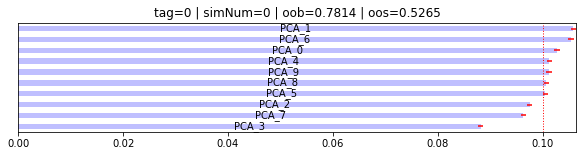

In [20]:
test_data_func(Xdot, cont, methods=['MDI'])

## Base dataframe

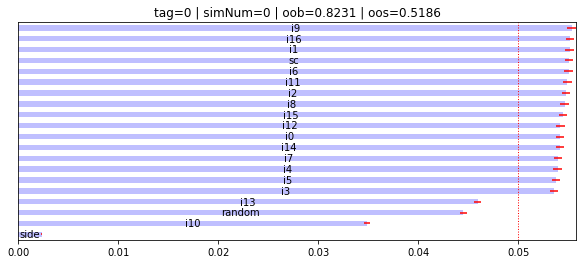

In [21]:
test_data_func(X, cont, methods=["MDI"])

## Combined dataframe

In [22]:
Xdotdot = pd.concat([X, Xdot], axis=1)
Xdotdot.columns

Index(['i0', 'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'i10',
       'i11', 'i12', 'i13', 'i14', 'i15', 'i16', 'side', 'sc', 'random',
       'PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7',
       'PCA_8', 'PCA_9'],
      dtype='object')

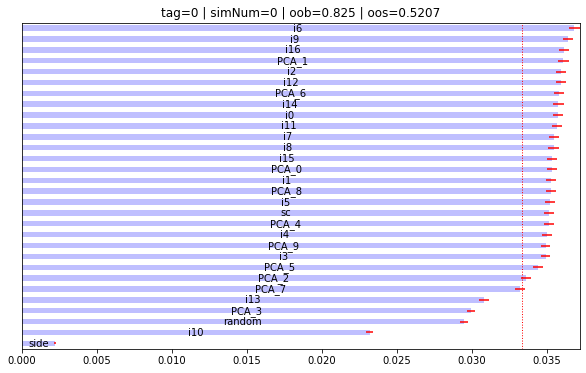

In [23]:
test_data_func(Xdotdot, cont, methods=["MDI"])

## Tau

In [24]:
feature_imp, oob_score, oos_score = featImportance(Xdot, cont, cv=5, method='MDI')

In [25]:
feature_imp

,mean,std
PCA_0,0.103104,0.000530
PCA_1,0.106157,0.000568
PCA_2,0.097444,0.000490
PCA_3,0.087302,0.000457
PCA_4,0.101358,0.000517
PCA_5,0.101373,0.000534
PCA_6,0.105046,0.000539
PCA_7,0.095963,0.000495
PCA_8,0.100891,0.000510
PCA_9,0.101362,0.000497


In [26]:
featImp=np.array(feature_imp["mean"]) # feature importance 
pcRank=np.arange(1, len(feature_imp)+1) # PCA rank
weightedtau(featImp,pcRank**-1.)[0]

0.2983185054720078